#Flow Matching
*   Yêu cầu: Thay thế code vào các đoạn None bên dưới để hoàn thành quá trình training và sampling cho mô hình Flow Matching

Lưu ý:
1. Chỉ được thay đổi code trong vùng yêu cầu
2. Run with CPU

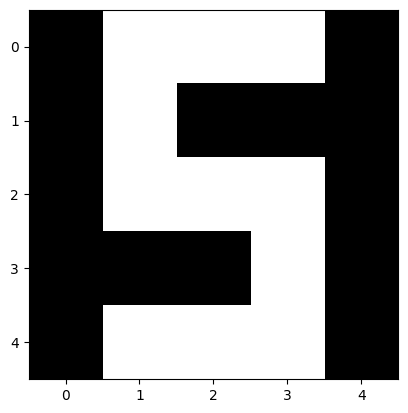

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

#!!! Run with CPU !!!#

image_5 = torch.tensor([
    [0, 1, 1, 1, 0],
    [0, 1, 0, 0, 0],
    [0, 1, 1, 1, 0],
    [0, 0, 0, 1, 0],
    [0, 1, 1, 1, 0]
], dtype=torch.float32).unsqueeze(0).unsqueeze(0)

plt.imshow(image_5[0][0], cmap='gray')
plt.show()

In [2]:
class Flow(nn.Module):
  def __init__(self) -> None:
    super().__init__()

    self.time_embed = nn.Linear(1, 1)

    self.encoder = nn.Sequential(
        nn.Conv2d(1, 4, kernel_size=3, padding=1),
        nn.ELU(),
        nn.Conv2d(4, 4, kernel_size=3, padding=1),
        nn.ELU()
        )

    self.decoder = nn.ConvTranspose2d(4, 1, kernel_size=3, padding=1)

  def forward(self,  t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    t_embed = self.time_embed(t.unsqueeze(-1).float())
    t_embed = t_embed.view(-1, 1, 1, 1)

    # START YOUR CODE
    # Mở rộng t_embed để khớp với kích thước không gian của x
    t_embed_expanded = t_embed.expand(-1, 1, x.size(2), x.size(3))

    # Kết hợp đặc trưng thời gian và đầu vào (bằng phép cộng để giữ số kênh)
    x_t_combined = x + t_embed_expanded

    # Mã hóa đầu vào
    x_encoded = self.encoder(x_t_combined)

    # Giải mã và trả về kết quả
    return self.decoder(x_encoded)
    # END YOUR CODE


In [3]:
torch.manual_seed(42)

model = Flow()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()

losses = []
steps = 100

x_1 = image_5
for step in range(steps):
    torch.manual_seed(42)
    optimizer.zero_grad()
    x_0 = torch.randn_like(x_1)
    t = torch.rand(1)

    # START YOUR CODE
    target = x_1 - x_0  # Vector trường mục tiêu (gradient của ODE)
    x_t = t * x_1 + (1-t) * x_0  # Nội suy tuyến tính giữa x_0 và x_1
    pred = model(t, x_t)  # Dự đoán vector trường tại thời điểm t
    # END YOUR CODE

    loss = loss_fn(pred, target)
    loss.backward()
    optimizer.step()
    if step % 99 == 0:
        losses += [loss.detach()]
        print(f"Step: {step}, loss: {loss.item()}")


Step: 0, loss: 1.332879900932312
Step: 99, loss: 2.769704587990418e-05


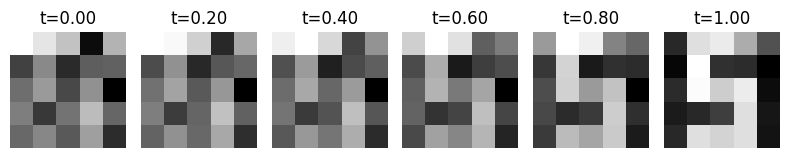

In [4]:
steps = 5
with torch.no_grad():
    torch.manual_seed(42)
    x_0 = torch.randn_like(x_1)
    t = torch.zeros(1)
    delta = 1/steps
    x_t = x_0
    list_x_t = [x_t]

    for i in range(steps):

        # START YOUR CODE
        x_t = x_t + model(t, x_t) * delta  # Cập nhật vị trí dựa trên vector vận tốc
        t = t + delta  # Cập nhật thời gian
        # END YOUR CODE

        list_x_t.append(x_t)

fig, axes = plt.subplots(1, len(list_x_t), figsize=(8, 3))
for i, x_t in enumerate(list_x_t):
    img = x_t.squeeze().detach().cpu().numpy()
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"t={i * delta:.2f}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()
